Moving white queen from coord(1, -1, 0) to coord(3, 0, -3).


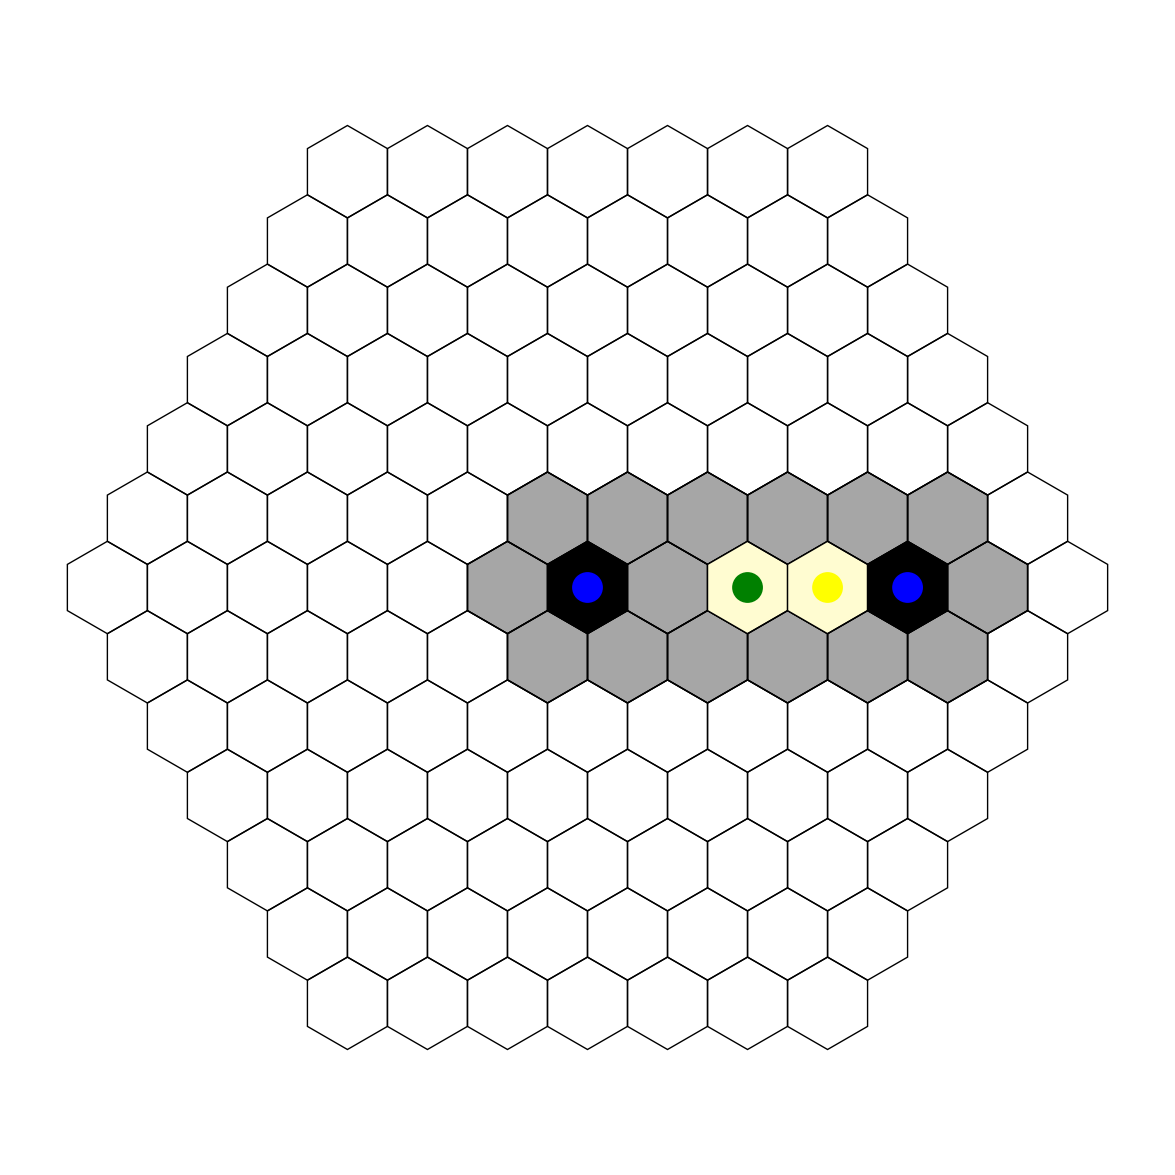

Valid game state: False
Move is legal: False


In [16]:
import importlib
import sys

from src.cell import CubeCoordinates

sys.path.append("src")

import board
import cell
import piece
import game_engine
import GUI
importlib.reload(board)
importlib.reload(cell)
importlib.reload(piece)
importlib.reload(game_engine)
importlib.reload(GUI)
from board import Board
from cell import Cell
from piece import Piece, Ant, Queen, Spider, Grasshopper, Beetle
from game_engine import Game
from GUI import GUI
from cell import Cell, GridCoordinates


board_halfwidth_t = 6
cell_size_t = 1
canvas_size_t = 25

g = Game(board_halfwidth_t)
ui = GUI(g, cell_size=cell_size_t, canvas_size=canvas_size_t)

c1 = GridCoordinates(0,0)
c2 = GridCoordinates(1,+0)
c3 = GridCoordinates(2,0,- 2)
c4 = GridCoordinates(1,-1,0)
c5 = GridCoordinates(3,-1,-2)
c6 = GridCoordinates(3,0,-3)
c7 = GridCoordinates(4,0,-4)

ant1=Ant(Piece.PieceColour.BLACK)
ant2=Ant(Piece.PieceColour.BLACK)
ant3=Ant(Piece.PieceColour.BLACK)
grasshopper1=Grasshopper(Piece.PieceColour.WHITE)
queen=Queen(Piece.PieceColour.WHITE)

ui.place_piece(c1,ant1)
#ui.place_piece(c2,ant2)
ui.place_piece(c3,grasshopper1)
ui.place_piece(c4,queen)
ui.place_piece(c7,ant3)

ui.move_piece(c4,c6,queen)
ui.draw_outer_border()

ui.draw_board()
ui.show_canvas()

print(f"Valid game state: {g.is_valid_state()}")
#TODO This is not correct - problem with piece comparison (probably comparing different objects)
print(f"Move is legal: {g.is_move_legal(c1,c6,ant2)}")


